In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import json
import torch
import cv2

from tqdm import tqdm
from skimage.color import rgb2lab, lab2rgb
from typing import List, Dict, Tuple
from numba import njit
from scipy.ndimage import center_of_mass
from skimage import draw
from skimage.io import imsave

from src.utils import *
from src.refine_transform import *
from src.find_transform import *
from src.shape_align import new_pairwise_alignment

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

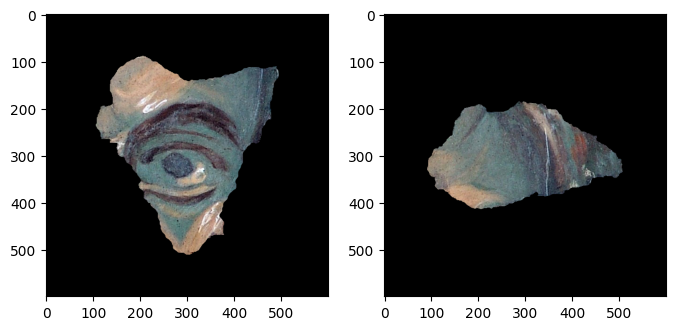

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [5]:
# load dict from json
# refined_alignment = json.load(open("probs_merged.json", "r"))
refined_alignment = json.load(open("alignments/alignments2.json", "r"))

In [6]:
# parsing frag ids from json
ids = [int(k.split("_")[0]) for k in refined_alignment.keys()]
ids.extend([int(k.split("_")[1]) for k in refined_alignment.keys()])
ids = sorted(list(set(ids)))
print(ids)
frag_numbers = ids
map_id_to_idx = {frag_numbers[i]: i for i in range(len(frag_numbers))}
pad_size = 250
frags = [pad_fragment_to_size(build_fragment_from_directory(data_dir + '/' + str(num)), pad_size) for num in frag_numbers]

[3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 49, 53, 54, 59, 61, 65, 95, 96]


In [7]:
def json_based_to_idx_translation_dict(
    json_based: Dict[str, List],
    id_to_idx: Dict[int, int], 
    frag_numbers: List[int]) -> Dict[Tuple[int, int], List[Translation]]:
    res = {}
    for k, v in tqdm(json_based.items()):
        key = (id_to_idx[int(k.split("_")[0])], id_to_idx[int(k.split("_")[1])])
        res[key] = [Translation(*val.values()) for val in v]
    return res
    

In [8]:
refined_alignment = json_based_to_idx_translation_dict(refined_alignment, map_id_to_idx, frag_numbers)

100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 132476.17it/s]


# Watching results of previous stages

In [9]:
from src.reestimating import *
from src.visualize import *

In [10]:
print([(fr_num, i) for i, fr_num in enumerate(frag_numbers)])

[(3, 0), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (10, 6), (11, 7), (12, 8), (14, 9), (15, 10), (49, 11), (53, 12), (54, 13), (59, 14), (61, 15), (65, 16), (95, 17), (96, 18)]


In [11]:
def rotate_fragment(frag, angle, c=None):
    """
    fast rotate
    """
    # TODO: rotate edge_coords
    h, w = frag.fragment.shape[:2]
    if c is None:
        c = (w // 2, h // 2)
    m = cv2.getRotationMatrix2D(center=c, angle=angle, scale=1.0)
    fr = Fragment(
        cv2.warpAffine(frag.fragment, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.extended_frag, M=m, dsize=(w, h)),
        cv2.warpAffine(frag.mask * 255.0, M=m, dsize=(w, h)) == 255,
        cv2.warpAffine(frag.extended_mask * 255.0, M=m, dsize=(w, h)) == 255
    )
    if fr.fragment.max() > 1:
        fr.fragment = fr.fragment / 255.0
    if fr.extended_frag.max() > 1:
        fr.extended_frag = fr.extended_frag / 255.0
    return fr

Confidence = 0.8867401978516901, translation = Translation(x=-112, y=276, angle=0.0, confidence=0.8867401978516901, geom_score=0.9248989886569022)
Confidence = 0.6853409645219344, translation = Translation(x=-173, y=-276, angle=-144.2052198537362, confidence=0.6853409645219344, geom_score=0.8604342067628893)
Confidence = 0.543193349003573, translation = Translation(x=-193, y=-270, angle=-139.2052198537362, confidence=0.543193349003573, geom_score=0.843843909812035)


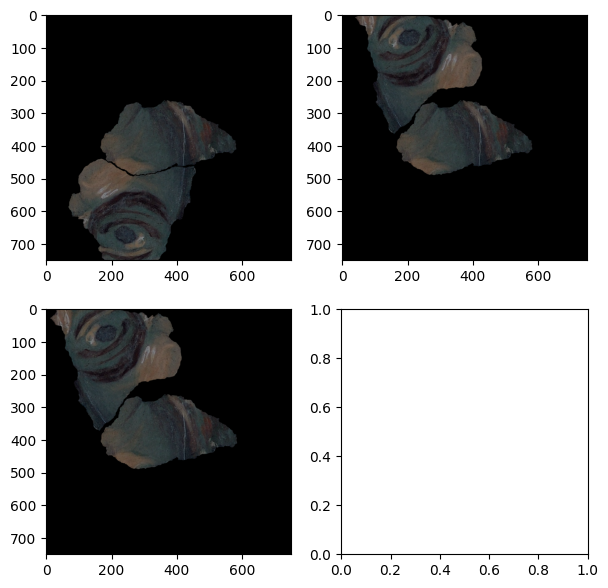

In [19]:
l, r = 5, 7

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i in range(len(refined_alignment[(l, r)][:4])):
    tr = refined_alignment[(l, r)][i]
    transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
    blended = blend_fragments(frags[r], transformed)
    
    axes[i // 2][i % 2].imshow(blended.fragment)
#     print(rotate_fragment(pad_fragment_to_size(frags[l], 200), 0).fragment.max())
#     axes[i // 2][i % 2].imshow(pad_fragment_to_size(frags[l], 200).fragment)
    
    print(f"Confidence = {tr.confidence}, translation = {tr}")


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


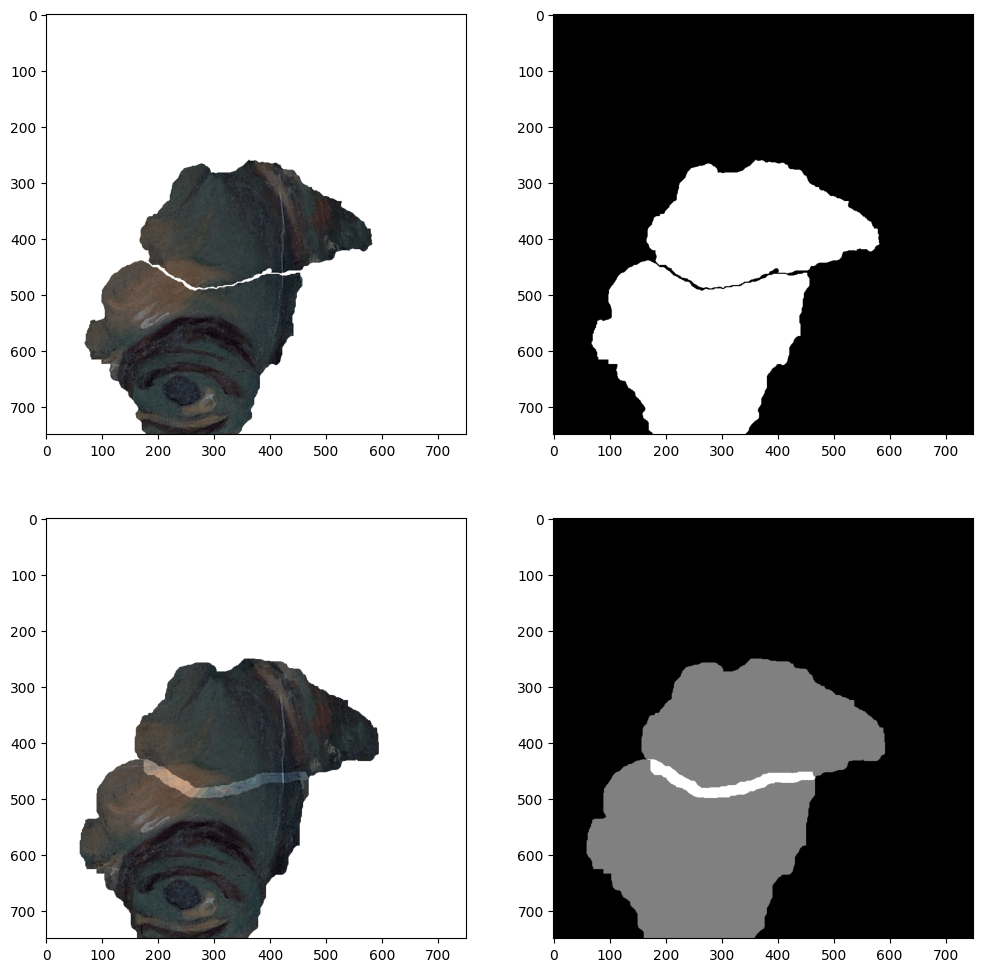

In [29]:
l, r = 5, 7
i = 0
tr = refined_alignment[(l, r)][i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], pad_size), tr.angle), tr.x, tr.y)
blended = blend_fragments(frags[r], transformed)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
# axes.imshow(blended.fragment)

# visualize_fragment(blended)
blended.fragment[blended.mask == 0] = 1
blended.extended_frag[blended.extended_mask == 0] = 1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes[0][0].imshow(blended.fragment)
axes[0][1].imshow(blended.mask, cmap='gray')
axes[1][0].imshow(blended.extended_frag)
axes[1][1].imshow(blended.extended_mask, cmap='gray')

imsave("../illustrations/blended_frag.png", blended.fragment)
imsave("../illustrations/blended_mask.png", blended.mask)
imsave("../illustrations/blended_extended_frag.png", blended.extended_frag)
imsave("../illustrations/blended_extended_mask.png", blended.extended_mask)

# Reestimating

In [13]:
print([(fr_num, i) for i, fr_num in enumerate(frag_numbers)])

[(3, 0), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (10, 6), (11, 7), (12, 8), (14, 9), (15, 10), (49, 11), (53, 12), (54, 13), (59, 14), (61, 15), (65, 16), (95, 17), (96, 18)]


In [14]:
# anchor_i, second_i, third_i = 2, 3, 5
anchor_i, second_i, third_i = 5, 1, 2
anchor = frags[anchor_i]
second = frags[second_i]
third = frags[third_i]
transform1 = refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)][0]
transform2 = refined_alignment[(anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)][1]

In [15]:
def visualize_triplet(frag1, frag2, frag3):
    fr1, fr2, fr3 = frag1.fragment, frag2.fragment, frag3.fragment
    if fr1.max() > 1:
        fr1 = fr1 / 255.0
    if fr2.max() > 1:
        fr2 = fr2 / 255.0
    if fr3.max() > 1:
        fr3 = fr3 / 255.0
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    merged_fragment = fr1 + fr2 + fr3
    mask = frag1.mask + frag2.mask + frag3.mask
    axes[0].imshow(merged_fragment)
    axes[1].imshow(mask)

In [28]:
transformed1 = transform_fragment(second, transform1, transpose=second_i > anchor_i)
transformed2 = transform_fragment(third, transform2, transpose=third_i > anchor_i)

visualize_triplet(anchor, transformed1, transformed2)

TypeError: transform_fragment() got an unexpected keyword argument 'transpose'

In [17]:
def check_if_two_fragments_are_too_far(frag1, frag2):
    """
    return True if two frags are too far from each other
    """
    center1 = center_of_mass(frag1.mask)
    center2 = center_of_mass(frag2.mask)
    start = (int(center1[0]), int(center1[1]))
    end = (int(center2[0]), int(center2[1]))
    line = draw.line(*start, *end)
    points = zip(line[0], line[1])
    belong_to_any_frag = [frag1.mask[p[0], p[1]] or frag2.mask[p[0], p[1]] for p in points]
    bad_points_number = len(belong_to_any_frag) - sum(belong_to_any_frag)
    return bad_points_number / len(belong_to_any_frag) > 0.33

In [18]:

def estimate_triplet(
    anchor: Fragment,
    second: Fragment,
    third: Fragment, 
    transform1: Translation, 
    transform2: Translation,
    transpose1: bool = False,
    transpose2: bool = False,
    verbose: int = 1
):
    """
    anchor: acnhor fragment 
    second: non-shifted neihgbor
    third: non-shifted neighbor, which is used to estimate pair (anchor, second), third neighbor
    transform1: Translation, transform to be used to align second 
    transform2: Translation, transform to be used to align third
    
    return: bool, is the triplet good
    """
#     print("Checking if too far or intersects too much")
    tr1 = transform_fragment(second, transform1, transpose1)
    tr2 = transform_fragment(third, transform2, transpose2)
    if check_if_two_fragments_are_too_far(tr1, tr2):
        print("Too far")
        return False
    if check_if_fragments_intersect_too_much(tr1, tr2):
        print("Too much intersection")
        return False
    
    transf1_neighbourhood = generate_transform_neighborhood(transform1)
    transf2_neighbourhood = generate_transform_neighborhood(transform2)
    
    # iterate over neighborhood
    print("creating neighbor fragments...")
    transformed1_lst = [transform_fragment(second, tr1, transpose=transpose1) for tr1 in (tqdm(transf1_neighbourhood) if verbose else transf1_neighbourhood)]
    transformed2_lst = [transform_fragment(third, tr2, transpose=transpose2) for tr2 in transf2_neighbourhood]
    print("iterating over neighbor fragments...")
    for transformed1 in tqdm(transformed1_lst) if verbose else transformed1_lst:
        for transformed2 in transformed2_lst:
            common_ext_intersection_exists = check_common_ext_intersection(anchor, transformed1, transformed2)
            if not common_ext_intersection_exists:
                continue
            common_intersection_exists = check_common_intersection(anchor, transformed1, transformed2)
            if common_intersection_exists:
                continue
                
            geom_score2_3 = compute_geom_morph_score(transformed1, transformed2)
            if geom_score2_3 < 0.6:
                continue
                
            geom_score1_2 = compute_geom_morph_score(anchor, transformed1)
            if geom_score1_2 < 0.6:
                continue
                
            geom_score1_3 = compute_geom_morph_score(anchor, transformed2)
            if geom_score1_3 < 0.6:
                continue
            return (transformed1, transformed2)
#             if geom_score1_2 > 0.6 and geom_score2_3 > 0.6 and geom_score1_3 > 0.6:
#                 return (transformed1, transformed2)
    return False

def iou(a, b):
    return (a & b).sum() / (a | b).sum()

def compute_geom_morph_score(frag1, frag2, structure_elem=np.ones((25, 25))):
    """
    params:
    frag1, frag2: two fragments to check
    structure_elem: morphological structuring element for morphological closing
    suitable geometric score for reestimating: 1 - gap / extended intersection
    """
    two_mask = np.logical_or(frag1.mask, frag2.mask)
    wide_intersection = np.logical_and(frag1.extended_mask, frag2.extended_mask)
    merged = cv2.morphologyEx(two_mask * 1.0, cv2.MORPH_CLOSE, structure_elem, iterations=1)
    wide_union = np.logical_or(frag1.extended_mask, frag2.extended_mask)
    intersection_sum = wide_intersection.sum()
    if intersection_sum / two_mask.sum() < 0.0025:
        return 0
    
    if len(wide_union.shape) == 2:
        wide_union = wide_union[:,:,None]
    if len(wide_intersection.shape) == 2:
        wide_intersection = wide_intersection[:,:,None]
    if len(two_mask.shape) == 2:
        two_mask = two_mask[:,:,None]
        
    gap = wide_intersection & merged[:,:,None].astype(bool) & np.logical_not(two_mask)
    gap_sum = gap.sum()
    if gap_sum == 0:
        return 0
    
    extended_gap = cv2.dilate(gap.astype(np.uint8), np.ones((10, 10)), iterations=1).astype(bool)
    if iou(wide_intersection, extended_gap[:,:,None]) < 0.6:
        return 0
    return (1 - gap_sum / intersection_sum)

In [19]:
res = estimate_triplet(anchor, second, third, transform1, transform2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)

creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.51it/s]


iterating over neighbor fragments...


 63%|███████████████████████████████████████████████████▊                              | 79/125 [00:08<00:04,  9.56it/s]


Good triplet! Found good frag positions


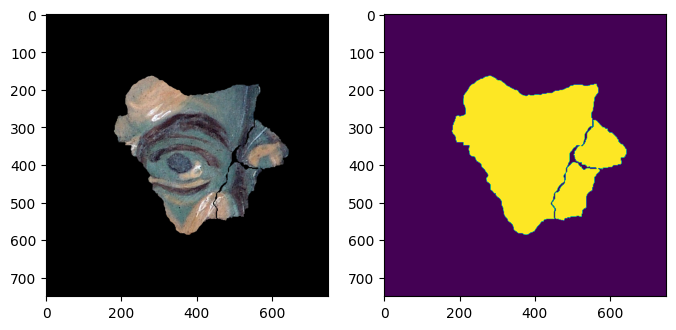

In [20]:
if res != False:
    print("Good triplet! Found good frag positions")
    visualize_triplet(anchor, res[0], res[1])
else:
    print("Bad triplet!")

In [33]:
triplet = anchor.fragment / 255 + res[0].fragment + res[1].fragment
mask = anchor.mask | res[0].mask | res[1].mask
triplet[np.logical_not(mask)] = 1

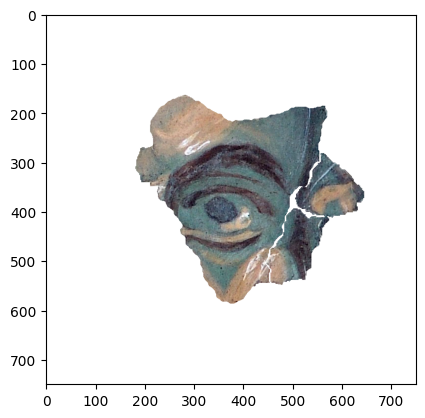

In [34]:
plt.imshow(triplet)

In [35]:
imsave("../illustrations/triplet.png", triplet)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


## End of debugged code

## In progress: analyzing all possible triplets

In [19]:
print([(i, frag_numbers[i]) for i in range(len(frag_numbers))])

[(0, 3), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11), (8, 12), (9, 14), (10, 15), (11, 49), (12, 53), (13, 54), (14, 59), (15, 61), (16, 65), (17, 95), (18, 96)]


In [20]:
anchor_i = 3
anchor = frags[anchor_i]

In [36]:
# matches = []
for second_i in range(10, 17):
    second = frags[second_i]
    for third_i in range(second_i + 1, len(frag_numbers)):
        print(f"Estimating triplet ({anchor_i}, {second_i}, {third_i})")
        third = frags[third_i]
        if third_i == second_i or third_i == anchor_i:
            continue
        key1 = (anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)
        key2 = (anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)
        if key1 not in refined_alignment or key2 not in refined_alignment:
            continue
        for tr_idx_1, tr1 in enumerate(refined_alignment[key1]):
            for tr_idx_2, tr2 in enumerate(refined_alignment[key2]):
                if tr_idx_1 + tr_idx_2 >= 3:
                    continue
                res = estimate_triplet(anchor, second, third, tr1, tr2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)
                if not res:
                    continue
                matches.append(res)

Estimating triplet (3, 10, 11)
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 10, 12)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 34.73it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.52it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 36.07it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:17<00:00,  7.31it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 33.00it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.46it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 30.89it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.07it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 27.13it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.72it/s]


Estimating triplet (3, 10, 13)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 28.89it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 18.10it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 26.54it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 19.33it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 33.85it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.31it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 26.83it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.05it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 27.09it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 20.35it/s]


Too far
Estimating triplet (3, 10, 14)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 35.58it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.85it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.74it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 20.97it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 29.64it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 20.97it/s]


Estimating triplet (3, 10, 15)
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Estimating triplet (3, 10, 16)
Too far
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 10, 17)
Estimating triplet (3, 10, 18)
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Estimating triplet (3, 11, 12)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 38.58it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 36.54it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 11.13it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 36.67it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:21<00:00,  5.69it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 39.57it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.79it/s]


Estimating triplet (3, 11, 13)
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 11, 14)
Too much intersection
Too much intersection
Estimating triplet (3, 11, 15)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 39.29it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.07it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 41.44it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 12.90it/s]


Too far
Too far
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.76it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.26it/s]


Estimating triplet (3, 11, 16)
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Too much intersection
Estimating triplet (3, 11, 17)
Estimating triplet (3, 11, 18)
Too far
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.90it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [01:26<00:00,  1.45it/s]


Too far
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.20it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [02:18<00:00,  1.11s/it]


Estimating triplet (3, 12, 13)
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 12, 14)
Too much intersection
Too much intersection
Estimating triplet (3, 12, 15)
Too much intersection
Too much intersection
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.58it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.94it/s]


Too much intersection
Too much intersection
Estimating triplet (3, 12, 16)
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 12, 17)
Estimating triplet (3, 12, 18)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 44.07it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.16it/s]


Too much intersection
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 40.35it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 19.17it/s]


Too much intersection
Estimating triplet (3, 13, 14)
Too far
Too far
Too far
Estimating triplet (3, 13, 15)
Too far
Too far
Too much intersection
Too far
Too far
Too far
Estimating triplet (3, 13, 16)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 42.10it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 18.82it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 41.25it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.67it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.97it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.16it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.53it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.53it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.22it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.59it/s]


creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 44.62it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.02it/s]


Estimating triplet (3, 13, 17)
Estimating triplet (3, 13, 18)
Too much intersection
Too far
Too much intersection
Too far
Too much intersection
Estimating triplet (3, 14, 15)
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 46.84it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:08<00:00, 14.45it/s]


Too much intersection
Too far
Estimating triplet (3, 14, 16)
Too far
Too far
Too far
Estimating triplet (3, 14, 17)
Estimating triplet (3, 14, 18)
Too far
Too much intersection
Estimating triplet (3, 15, 16)
Too far
Too far
Too far
Too far
Too far
Too far
Estimating triplet (3, 15, 17)
Estimating triplet (3, 15, 18)
Too much intersection
Too much intersection
creating neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 45.26it/s]


iterating over neighbor fragments...


100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.54it/s]


Too much intersection
Too much intersection
Estimating triplet (3, 16, 17)
Estimating triplet (3, 16, 18)
Too far
Too far
Too far
Too far
Too far


In [22]:
# anchor_i, second_i = 5, 10
# anchor = frags[anchor_i]
# second = frags[second_i]
# matches = []
# for third_i in range(len(frag_numbers)):
#     print(f"Estimating triplet ({anchor_i}, {second_i}, {third_i})")
#     third = frags[third_i]
#     if third_i == second_i or third_i == anchor_i:
#         continue
#     for tr1 in refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)]:
#         for tr2 in refined_alignment[(anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)]:
#             res = estimate_triplet(anchor, second, third, tr1, tr2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)
#             if not res:
#                 continue
#             matches.append(res)
        

In [37]:
matches

[(<src.utils.Fragment at 0x7f7e28593850>,
  <src.utils.Fragment at 0x7f7e28595420>)]

In [31]:
# idx1 = 1
# idx2 = 2
# idx3 = 5
# second_i, third_i, anchor_i = sorted([idx2, idx3, idx1])
# print(second_i, third_i, anchor_i)

# anchor = frags[anchor_i]
# second = frags[second_i]
# third = frags[third_i]

# matches = []
# for tr1 in refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)]:
#     for tr2 in refined_alignment[(anchor_i, third_i) if anchor_i < third_i else (third_i, anchor_i)]:
#         res = estimate_triplet(anchor, second, third, tr1, tr2, transpose1=anchor_i<second_i, transpose2=anchor_i<third_i, verbose=1)
#         if not res:
#             continue
#         matches.append(res)



In [32]:
# matches

In [33]:
# if not res:
#     print("Triplet has not been found")
# else:
#     print("Triplet has been found")

In [34]:
# anchor, transformed1, transformed2 = res[0], res[3], res[4]
# transpose1, transpose2 = res[5], res[6]


# geom_score1_2 = compute_geom_morph_score(anchor, transformed1)
# geom_score1_3 = compute_geom_morph_score(anchor, transformed2)
# geom_score2_3 = compute_geom_morph_score(transformed1, transformed2)
# print(f"geom_scores = {geom_score1_2, geom_score1_3, geom_score2_3}")

# visualize_triplet(anchor, transformed1, transformed2)

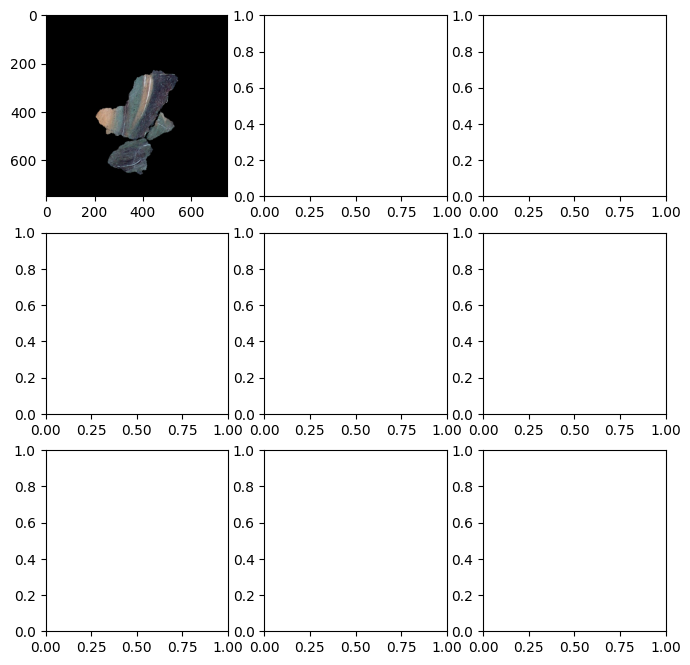

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        if i * 3 + j >= len(matches):
            break
        res = matches[i * 3 + j]
        transformed1, transformed2 = res[0], res[1]
        fr1, fr2, fr3 = anchor.fragment, transformed1.fragment, transformed2.fragment
        if fr1.max() > 1:
            fr1 = fr1 / 255.0
        if fr2.max() > 1:
            fr2 = fr2 / 255.0
        if fr3.max() > 1:
            fr3 = fr3 / 255.0
        axes[i, j].imshow(fr1 + fr2 + fr3)

geom_scores = (0.7701760212553969, 0.639121641144178, 0.6489637305699482)


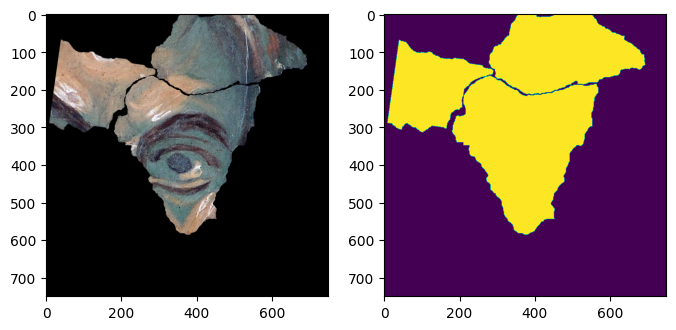

In [36]:
# transform1 = refined_alignment[(anchor_i, second_i) if anchor_i < second_i else (second_i, anchor_i)][0]
# transform2 = refined_alignment[(anchor_i, third_i) if anchor_i < third_idx else (third_idx, anchor_i)][0]
# print(l, r)
# if l > r:
#     transform1 = Translation(- transform1.x, - transform1.y, - transform1.angle, transform1.confidence, transform1.geom_score)

# anchor = res[0]
# second = res[1]
# third = res[2]
# transform1 = res[3]
# transform2 = res[4]
# transpose1 = res[5]
# transpose2 = res[6]

# l, r, third = 
res = matches[2]
# i1, i2, i3 = 15, 14, 16
# anchor = frags[i1]
# second = frags[i2]
# third = frags[i3]

second, third = res
# transform1 = refined_alignment[(i2, i1) if i2 < i1 else (i1, i2)][0]
# transform2 = refined_alignment[(i3, i1) if i3 < i1 else (i1, i3)][0]
# transpose1 = i1 < i2
# transpose2 = i1 < i3

# if l < r:
#     transformed = rotate_fragment(pad_fragment_to_size(second, 200), transform1.angle)
#     transformed = shift_fragment(transformed, transform1.x, transform1.y)
# else: # if l > r, first shift, then rotate
#     transformed = shift_fragment(pad_fragment_to_size(second, 200), transform1.x, transform1.y)
#     transformed = rotate_fragment(transformed, transform1.angle)
# transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(second, 200), transform1.angle), transform1.x, transform1.y)

# transformed2 = transform_fragment(second, Translation(transform1.x, transform1.y, transform1.angle, transform1.confidence, transform1.geom_score), transpose=transpose1)
# transformed3 = transform_fragment(third, Translation(transform2.x, transform2.y, transform2.angle, transform2.confidence, transform2.geom_score), transpose=transpose2)

transformed2 = res[0]
transformed3 = res[1]
# transformed
# print(f"is possible = {check_possibility_of_triplet(anchor, transformed2, transformed3)}")
# visualize_fragment(blend_fragments(blend_fragments(anchor, transformed2), transformed3))
visualize_triplet(anchor, transformed2, transformed3)
geom_score1_2 = compute_geom_morph_score(anchor, transformed2)
geom_score1_3 = compute_geom_morph_score(anchor, transformed3)
geom_score2_3 = compute_geom_morph_score(transformed2, transformed3)
print(f"geom_scores = {geom_score1_2, geom_score1_3, geom_score2_3}")